# SkimLit :

The purpose of this notebook is to build an NLP model to make reading medical abstracts (from pubmed etc) easier.

The paper being implemented here is : [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

Model : [Neural networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf)

In [ ]:
!nvidia-smi

Fri Sep 10 19:24:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Starting experiments using the 20k dataset with numbers replaced by '@'

In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
# Preprocess data
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 564 ms, sys: 83.4 ms, total: 648 ms
Wall time: 652 ms


In [ ]:
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

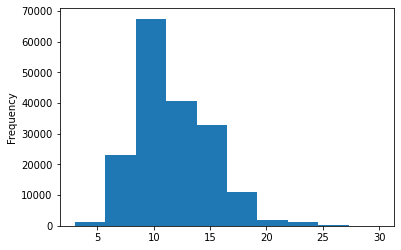

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
# get lists of sentences
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Making Numeric Lables


In [ ]:
# One hot encode lables
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

### Model 0: TF-IDF Multinomial Naivee Bayes classifier (baseline)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
#eval on validation dataset

model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Making predictions 
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# Helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-10 19:25:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-10 19:25:06 (74.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing data (the text) for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

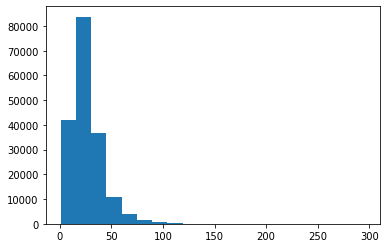

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

#### Creating a text vectorizer layer

In [ ]:
# How many words are in the vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len) # rest parametrs are left default

In [ ]:
# Adapt to train_sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
#test it out on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
sod-melon concentrate supplementation appears to be an effective and natural way to reduce stress and fatigue .

Length of text: 17

Vectorized text:
[[24560  6548   464  1403     6    36    26   137     3  2266  1767     6
    270   401     3   648     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in the training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

#### Creating a custom text embedding

In [ ]:
#Token embedding layer

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
sod-melon concentrate supplementation appears to be an effective and natural way to reduce stress and fatigue .

Sentence after vectorization (before embedding):
[[24560  6548   464  1403     6    36    26   137     3  2266  1767     6
    270   401     3   648     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02798072 -0.04225275  0.01442008 ...  0.03173429  0.01047958
    0.02611664]
  [ 0.04230301 -0.02682674  0.00928563 ... -0.02530881  0.04333526
    0.01484121]
  [-0.04681448 -0.03630242 -0.04812095 ...  0.0491404  -0.03333788
   -0.00381839]
  ...
  [-0.00302549  0.04091983  0.04650393 ...  0.01104669 -0.01539637
   -0.03459935]
  [-0.00302549  0.04091983  0.04650393 ...  0.01104669 -0.01539637
   -0.03459935]
  [-0.00302549  0

### Creating Datasets (making sure the data loads as fast as possible)

With the help of Tensorflow tf.data API

In [ ]:
#turn data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
#Taking these TensorSliceDatasets and turning them into prefetched datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1 : Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 14ms/step - loss: 0.9141 - accuracy: 0.6376 - val_loss: 0.6905 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6648 - accuracy: 0.7516 - val_loss: 0.6410 - val_accuracy: 0.7686
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6246 - accuracy: 0.7697 - val_loss: 0.6020 - val_accuracy: 0.7832


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6051 - accuracy: 0.7831


[0.6051335334777832, 0.7830994129180908]

In [ ]:
#making predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.29416865e-01, 1.98664129e-01, 6.57130182e-02, 2.80769497e-01,
         2.54364014e-02],
        [4.50588793e-01, 2.81171858e-01, 1.15941474e-02, 2.48192102e-01,
         8.45314935e-03],
        [1.84669569e-01, 8.49978067e-03, 1.87093182e-03, 8.04928839e-01,
         3.08706258e-05],
        ...,
        [4.18828768e-06, 8.89739196e-04, 6.84426748e-04, 3.28844703e-06,
         9.98418331e-01],
        [5.33122532e-02, 4.79564637e-01, 1.00362055e-01, 6.07164986e-02,
         3.06044549e-01],
        [1.90409914e-01, 6.31514132e-01, 4.73538041e-02, 5.43731898e-02,
         7.63489679e-02]], dtype=float32), (30212, 5))

In [ ]:
#converting pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
#calc model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.30994306897921,
 'f1': 0.7807897981466561,
 'precision': 0.779840282754304,
 'recall': 0.7830994306897922}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 2: Feature Extraction with pretrained token embeddings

TFHUB Universal sentence encoder in particular : https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
#download pretraied tf hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
# test on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
cardiac function and toxicity were also examined .

Sentence after embedding:
[-0.03661579  0.06864902  0.00200397  0.04187519  0.07645909 -0.07436219
  0.00537442 -0.05078091 -0.0100573   0.00430481  0.08469503 -0.03333426
  0.06510819  0.05774224 -0.08075918 -0.03618075 -0.0864962  -0.01907723
  0.02996689  0.05183792 -0.02778549  0.04181122  0.03371915 -0.05352426
 -0.02400026 -0.05821601 -0.08025075  0.03818772 -0.01367629  0.05525747] (truncated output)...

Length of sentence embedding:
512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs,outputs,name='model_2_USE_feature_extractor')

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 21ms/step - loss: 0.9189 - accuracy: 0.6490 - val_loss: 0.7994 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7706 - accuracy: 0.7008 - val_loss: 0.7575 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7545 - accuracy: 0.7109 - val_loss: 0.7404 - val_accuracy: 0.7131


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7427 - accuracy: 0.7130


[0.7427242398262024, 0.7129948139190674]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.5894706e-01, 3.3502826e-01, 2.3515874e-03, 1.9628824e-01,
        7.3848190e-03],
       [3.4461394e-01, 4.9286541e-01, 2.9663339e-03, 1.5683697e-01,
        2.7173886e-03],
       [2.3878789e-01, 1.5826517e-01, 1.8704550e-02, 5.4911876e-01,
        3.5123590e-02],
       ...,
       [1.7882958e-03, 5.6786030e-03, 6.2505208e-02, 8.7539252e-04,
        9.2915249e-01],
       [3.9049997e-03, 4.6231639e-02, 1.9365087e-01, 1.3032409e-03,
        7.5490928e-01],
       [1.9413278e-01, 2.7964887e-01, 4.6736321e-01, 7.6007396e-03,
        5.1254336e-02]], dtype=float32)

In [ ]:
#convert pred probs to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#calc results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.29948364888124,
 'f1': 0.7099998254596893,
 'precision': 0.7132838176765974,
 'recall': 0.7129948364888123}

In [ ]:
model_1_results

{'accuracy': 78.30994306897921,
 'f1': 0.7807897981466561,
 'precision': 0.779840282754304,
 'recall': 0.7830994306897922}

### Model 3: Conv1D with character embeddings




##### Creating a charater tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
  return " ".join(list(text))

# Text splitting non character level sequence into characters
split_chars(random_training_sentence)

'c a r d i a c   f u n c t i o n   a n d   t o x i c i t y   w e r e   a l s o   e x a m i n e d   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Whats the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)

mean_char_len

149.3662574983337

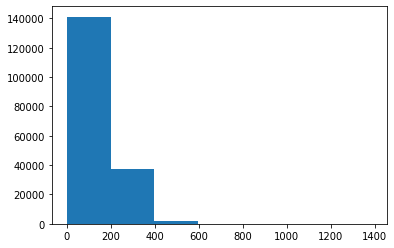

In [ ]:
# Checking the distribution of the sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Finding what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
#get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Creating a char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + UNK token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None,
                                    name='char_vectorizer')

In [ ]:
#Adapt charatcer vectorizer to training vectorizer
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   p u r p o s e   o f   t h i s   s t u d y   i s   t o   d e t e r m i n e   t h e   e f f e c t i v e n e s s   ,   i n   t e r m s   o f   e n g a g e m e n t   ,   r e t e n t i o n   ,   s a t i s f a c t i o n   a n d   p h y s i c a l   a c t i v i t y   c h a n g e s   ,   o f   a   w e b - b a s e d   a n d   c o m p u t e r - t a i l o r e d   p h y s i c a l   a c t i v i t y   i n t e r v e n t i o n   w i t h   a n d   w i t h o u t   t h e   a d d i t i o n   o f   a   b r i e f   v i d e o - b a s e d   c o a c h i n g   s e s s i o n   i n   c o m p a r i s o n   t o   a   c o n t r o l   g r o u p   .

Length of chars: 267

Vectorized chars:
[[ 3 13  2 14 16  8 14  7  9  2  7 17  3 13  4  9  9  3 16 10 19  4  9  3
   7 10  2  3  2  8 15  4  6  2  3 13  2  2 17 17  2 11  3  4 21  2  6  2
   9  9  4  6  3  2  8 15  9  7 17  2  6 18  5 18  2 15  2  6  3  8  2  3
   2  6  3  4  7  6  9  5  3  4  9 17  5 11  3  4  7  6  5  6 10 14 13 19
   9  4 11  5 1

##### Creating a character-level embedding


In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True,
                              name='char_embed')

In [ ]:
#Test the embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a   @ - w e e k   s t a n d a r d i z e d   a e r o b i c   d y n a m i c   e x e r c i s e   t r a i n i n g   p r o g r a m   (   @   o n e - h o u r   s e s s i o n s   p e r   w e e k   )   w a s   u s e d   .

Embedded chars (after vectorization and embedding):
[[[-0.02422873 -0.0201811  -0.01007973 ... -0.02530266  0.01913526
   -0.04422053]
  [-0.00899879 -0.04611385 -0.01899545 ...  0.04009943 -0.03193416
   -0.04968352]
  [ 0.03889816 -0.02252054 -0.03117979 ...  0.00444425 -0.02608463
   -0.01605079]
  ...
  [ 0.02800045  0.02655735  0.01381898 ... -0.04561719  0.00976495
   -0.02067585]
  [ 0.02800045  0.02655735  0.01381898 ... -0.04561719  0.00976495
   -0.02067585]
  [ 0.02800045  0.02655735  0.01381898 ... -0.04561719  0.00976495
   -0.02067585]]]

Character embedding shape: (1, 290, 25)


##### Building Conv1D to fit on character embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs,outputs,name='model_3_conv1d_char_embeddings')

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [ ]:
# Create char  level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.2554 - accuracy: 0.4944 - val_loss: 1.0254 - val_accuracy: 0.5971
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9857 - accuracy: 0.6065 - val_loss: 0.9266 - val_accuracy: 0.6363
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9157 - accuracy: 0.6412 - val_loss: 0.8559 - val_accuracy: 0.6725


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.18266045, 0.4853904 , 0.02095473, 0.2778861 , 0.03310842],
       [0.38733247, 0.42109656, 0.01770995, 0.12208272, 0.05177841],
       [0.08927607, 0.21410333, 0.1722042 , 0.43265244, 0.09176395],
       ...,
       [0.03983007, 0.06614471, 0.14941457, 0.03268947, 0.71192116],
       [0.02149149, 0.10137682, 0.612593  , 0.03057705, 0.23396167],
       [0.43899617, 0.37795034, 0.06041108, 0.11779132, 0.00485106]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 0])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.50337614193036,
 'f1': 0.6546746473996671,
 'precision': 0.6541062688296925,
 'recall': 0.6650337614193036}

### Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

In [ ]:
#Token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# Char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Combining 1 & 2 with concatenate (hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# Creating output layers -adding in Dropout, discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# Constructing model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

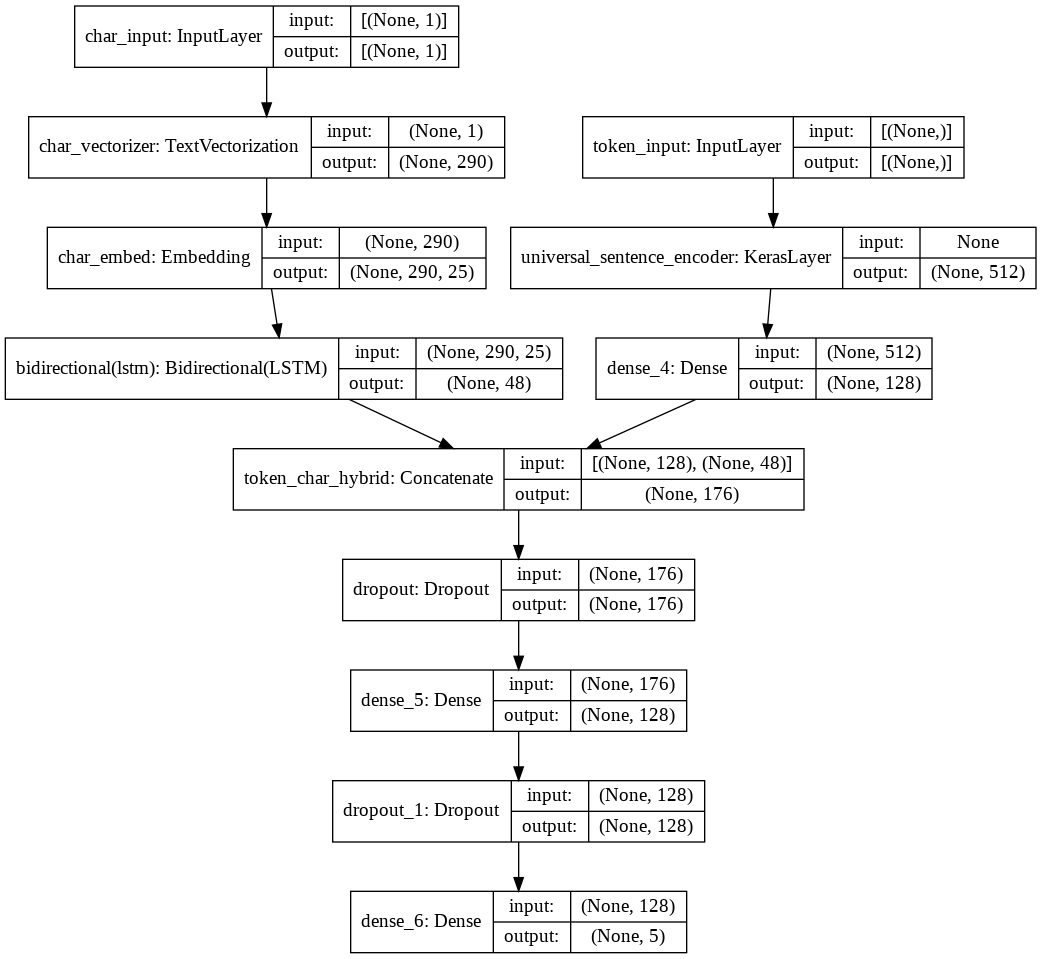

In [ ]:
# Plotting hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
 model_4.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

#### Combining token and character data into a tf.data Dataset

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

#prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

#### Fitting the model on token and character-level sequences

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 86s 135ms/step - loss: 0.9887 - accuracy: 0.6083 - val_loss: 0.7877 - val_accuracy: 0.7001
Epoch 2/3
562/562 [==============================] - 72s 129ms/step - loss: 0.8006 - accuracy: 0.6896 - val_loss: 0.7164 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.7749 - accuracy: 0.7063 - val_loss: 0.6899 - val_accuracy: 0.7397


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.6948 - accuracy: 0.7363


[0.6947553157806396, 0.7363299131393433]

In [ ]:
#Making predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.8241776e-01, 3.2202533e-01, 3.3076860e-03, 1.8732348e-01,
        4.9257479e-03],
       [3.5231137e-01, 4.9217430e-01, 3.3275685e-03, 1.5064810e-01,
        1.5386153e-03],
       [2.9649279e-01, 1.4223936e-01, 4.4716105e-02, 4.7860366e-01,
        3.7948046e-02],
       ...,
       [5.9876038e-04, 9.6536744e-03, 4.6348564e-02, 2.0347601e-04,
        9.4319546e-01],
       [5.9232232e-03, 6.4395167e-02, 1.6335331e-01, 2.7261812e-03,
        7.6360214e-01],
       [3.7975654e-01, 2.9270461e-01, 2.5038376e-01, 3.5041817e-02,
        4.2113211e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.63299351251158,
 'f1': 0.734191369351587,
 'precision': 0.736491091983936,
 'recall': 0.7363299351251158}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings


In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


#### Create Positional embeddings

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

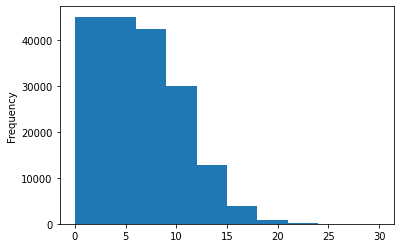

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
# Using TensorFlow to create one-hot-encoded tensors of the "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

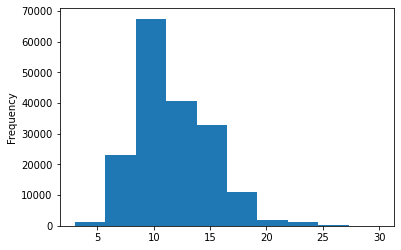

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

#### Building the tribrid embedding model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name='toal_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combining token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combining positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Putting toghether model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding_model')

In [ ]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

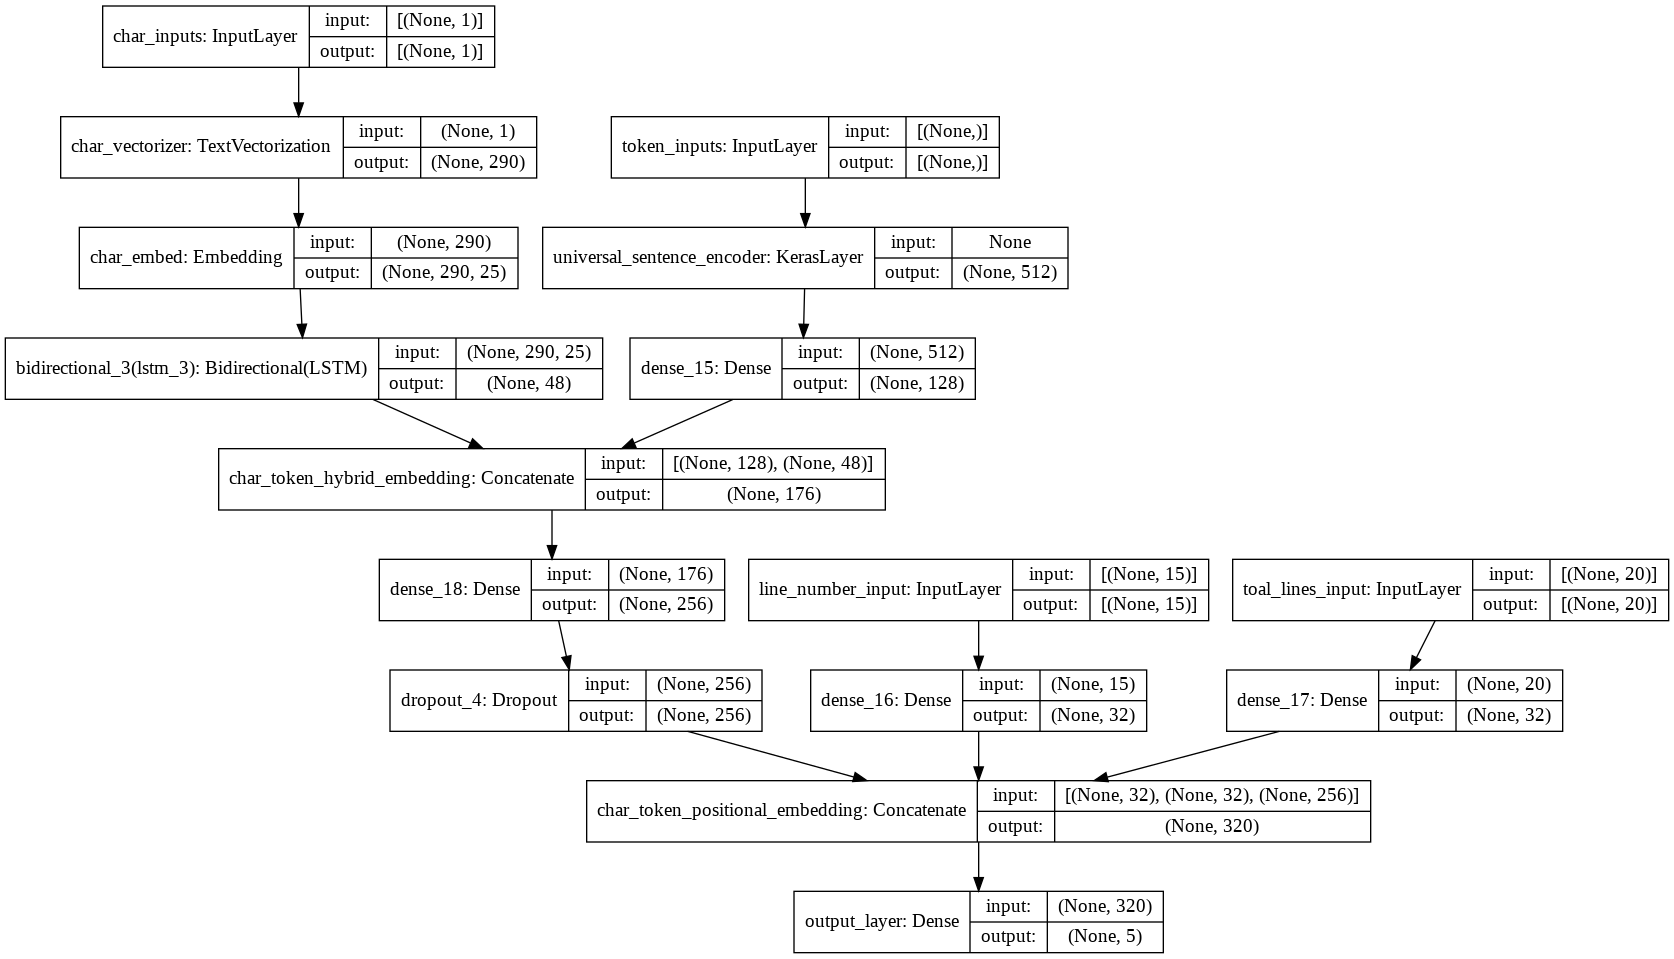

In [ ]:
# Ploting the Tribrid model
from keras.utils.vis_utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#### Creating Tribrid embedding datasets using tf.data

In [ ]:
#train dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Checking input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

#### Fitting, evaluating and making predictions with the Tribrid model

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 85s 133ms/step - loss: 1.0908 - accuracy: 0.7314 - val_loss: 0.9789 - val_accuracy: 0.8075
Epoch 2/3
562/562 [==============================] - 72s 128ms/step - loss: 0.9658 - accuracy: 0.8141 - val_loss: 0.9502 - val_accuracy: 0.8295
Epoch 3/3
562/562 [==============================] - 68s 120ms/step - loss: 0.9506 - accuracy: 0.8246 - val_loss: 0.9380 - val_accuracy: 0.8311


In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 49s 49ms/step


array([[0.49112153, 0.1035886 , 0.0121208 , 0.37456334, 0.01860569],
       [0.501237  , 0.10254998, 0.04602132, 0.3400823 , 0.01010951],
       [0.26111692, 0.10402253, 0.13603641, 0.42460817, 0.07421599],
       ...,
       [0.0348208 , 0.08376005, 0.03610894, 0.03397693, 0.8113333 ],
       [0.03213802, 0.2995289 , 0.08791361, 0.02860696, 0.5518125 ],
       [0.19700101, 0.56969446, 0.13274075, 0.04656511, 0.05399865]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.35098636303455,
 'f1': 0.832481787024247,
 'precision': 0.8323013659582597,
 'recall': 0.8335098636303455}

----

## Comparing model results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding_conv1d": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding_conv1d": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_tribrid_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding_conv1d,78.309943,0.779840,0.783099,0.780790
model_2_pretrained_token_embedding,71.299484,0.713284,0.712995,0.710000
model_3_custom_char_embedding_conv1d,66.503376,0.654106,0.665034,0.654675
model_4_hybrid_char_token_embedding,73.632994,0.736491,0.736330,0.734191
model_5_tribrid_pos_char_token_embedding,83.350986,0.832301,0.833510,0.832482


In [ ]:
# Reducing the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

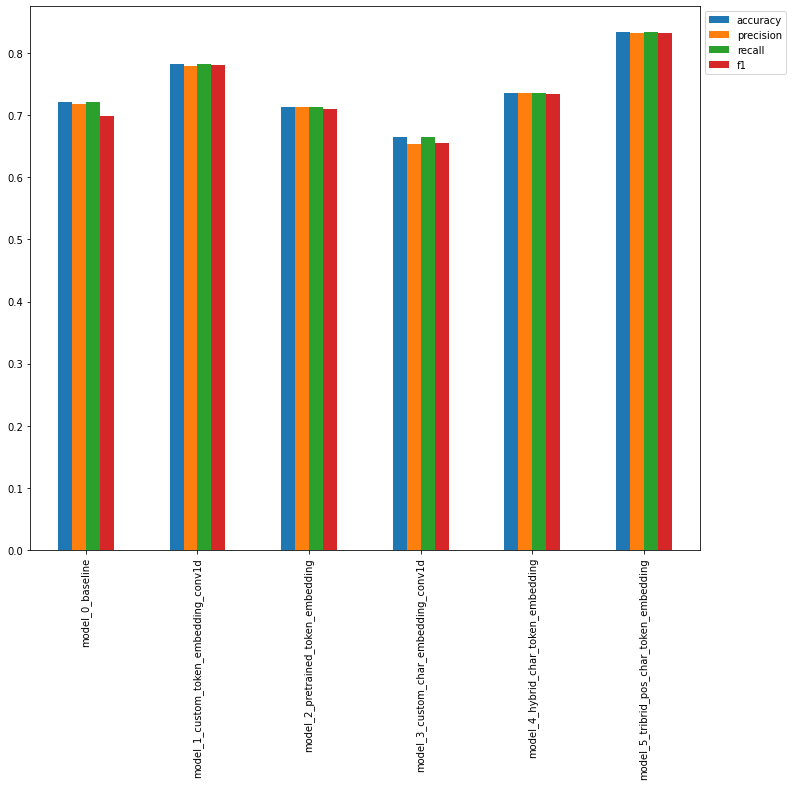

In [ ]:
all_model_results.plot(kind='bar', figsize=(12,10)).legend(bbox_to_anchor=(1.0, 1.0));

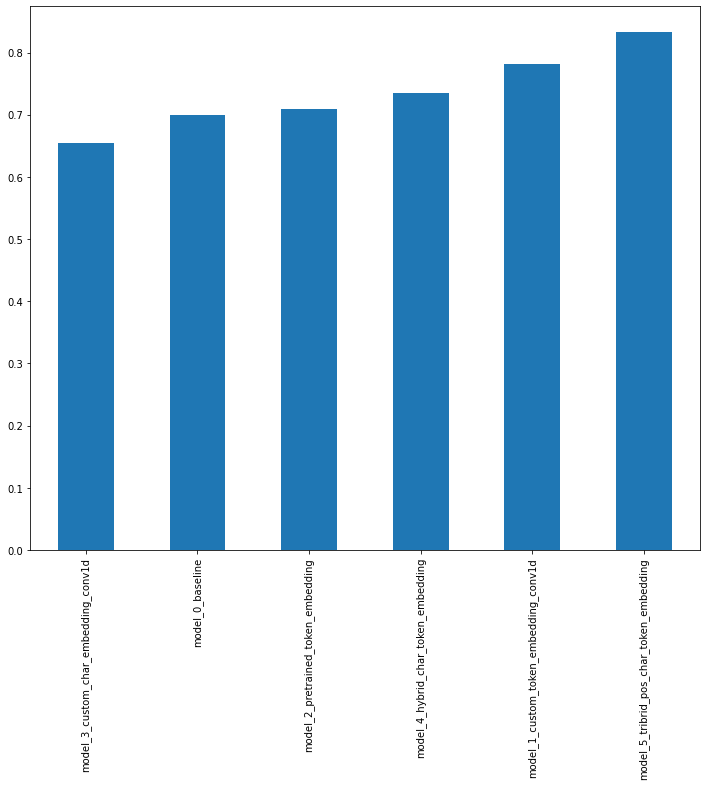

In [ ]:
#Sorting models results by f1 scores
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(12,10))

In [ ]:
model_5_results

{'accuracy': 83.35098636303455,
 'f1': 0.832481787024247,
 'precision': 0.8323013659582597,
 'recall': 0.8335098636303455}

### Eval on test dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 47s 50ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
model_5_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_5_test_results

{'accuracy': 82.84055085448814,
 'f1': 0.8273490364799482,
 'precision': 0.8269124194794136,
 'recall': 0.8284055085448814}

### Finding the most wrong

In [ ]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 15.8 s, sys: 1.53 s, total: 17.3 s
Wall time: 15.1 s


In [ ]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.477234,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.345796,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.777335,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.603480,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.755404,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.902460,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.614837,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.485681,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.452999,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.564097,True


In [ ]:
# Find top 100 most wrong samples
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.944615,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.932825,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.925944,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.922234,False
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,11,OBJECTIVE,0.919940,False
...,...,...,...,...,...,...,...
8573,RESULTS,"primary outcome was breastfeeding at @ days , ...",5,16,METHODS,0.828813,False
18789,BACKGROUND,these programs were evaluated in a head-to-hea...,3,12,METHODS,0.827517,False
29835,CONCLUSIONS,"by age @ years , subjects remained small and t...",10,13,RESULTS,0.827105,False
705,RESULTS,the bi requires further testing in a randomise...,12,14,CONCLUSIONS,0.826876,False


In [ ]:
for row in top_100_wrong[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9446150064468384, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9328247904777527, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9259443879127502, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9222339987754822, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9199397563934326, Line number: 0, Total lines: 11

Text:
to assess the temporal patterns of late gastrointestinal ( gi ) and genitourinary ( gu ) radiotherapy toxicity and resolution rates in a randomised controlled trial ( all-ireland coopera

## Make example predictions

In [ ]:
#to do

----
----

## Misc (saving the model)

In [ ]:
#savemodel format
model_5.save('skimlit_tribrid_model')

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


To do:
- MAKE EXAMPLE PREDICTIONS
- Add tensorboard callbacks 
- Train the model on the 200k dataset
- etc.

----
----
----